# Guild Membership Prediction Project

## Introduction
This project aims to predict guild membership in a fictional world using classification machine learning models. 
We evaluate three models: Logistic Regression, Random Forest, and Linear SVM.

- **Dataset Overview**: Includes 30+ features such as stamina, mystical indices, and wizardry skill.
- **Goal**: Explore the trade-offs between speed, interpretability, and accuracy across models.


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
import joblib

# Load dataset
df = pd.read_csv('guilds.csv')

# Subsample the dataset (25% of the original data for speed)
df = df.sample(frac=0.25, random_state=42)

# Dataset overview
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (63420, 31)


,Fae_Dust_Reserve,Physical_Stamina,Mystical_Index,Healer_consultation_Presence,Elixir_veggies_consumption_Presence,Mystic_Energy_Level,Bolt_of_doom_Presence,Age_of_Wisdom,High_willingness_Presence,Defense_spell_difficulty_Presence,...,Royal_family_pressure_Presence,Dragon_Sight_Sharpness,Guild_Membership,Enchanted_Coin_Count,Celestial_Alignment,Knightly_Valor,Heavy_elixir_consumption_Presence,Stigmata_of_the_cursed_Presence,Dragon_status_Presence,Rune_Power
219620,2.029478,2.0,18.0,Present,Absent,0.695450,Absent,6.0,Present,Absent,...,Absent,3.0,No_Guild,437.0,6.936719,2.0,Absent,Absent,Absent,54.455053
132821,15.778353,0.0,33.0,Present,Absent,2.164655,Present,8.0,Absent,Absent,...,Present,7.0,No_Guild,86.0,3.906065,4.0,NaN,Absent,Present,NaN
151862,8.191558,0.0,NaN,NaN,Present,0.829161,Absent,11.0,Absent,NaN,...,Present,NaN,Master_Guild,131.0,NaN,6.0,Absent,Absent,NaN,23.508421
139717,8.732955,0.0,27.0,Present,Absent,2.749203,Absent,10.0,NaN,Absent,...,Absent,7.0,No_Guild,260.0,2.219459,7.0,Absent,Absent,Absent,32.053674
239235,1.485253,0.0,NaN,NaN,Present,0.440877,Absent,13.0,Absent,Absent,...,Absent,2.0,No_Guild,197.0,5.177352,5.0,Absent,Absent,Absent,30.270844


### Dataset Overview
The dataset includes the following attributes:
- **Numerical**: Stamina, Mystical Index, Rune Power, etc.
- **Categorical**: Binary indicators like `Present`/`Absent` for specific traits.

We'll preprocess this data before training our models.


### Data Preprocessing
We handle missing values, encode the target variable, and standardize numerical features.
- **Missing Values**:
  - Numerical columns: Replaced with column mean.
  - Categorical columns: Replaced with column mode.
- **Encoding**:
  - Target variable is encoded to numeric classes.
  - Binary columns (`Present`/`Absent`) are mapped to `1`/`0`.


In [4]:
# Handle missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()), axis=0)
for col in categorical_cols:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Encode target variable
label_encoder = LabelEncoder()
df['Guild_Membership_encoded'] = label_encoder.fit_transform(df['Guild_Membership'])

# Map 'Present'/'Absent' to 1/0 for binary columns
presence_absence_columns = [
    'Healer_consultation_Presence',
    'Elixir_veggies_consumption_Presence',
    'Bolt_of_doom_Presence',
    'High_willingness_Presence',
    'Defense_spell_difficulty_Presence',
    'Doc_availability_challenge_Presence',
    'Dexterity_check_Presence',
    'Fruits_of_eden_consumption_Presence',
    'Knight_physical_training_Presence',
    'Royal_family_pressure_Presence',
    'Heavy_elixir_consumption_Presence',
    'Stigmata_of_the_cursed_Presence',
    'Dragon_status_Presence',
]
for col in presence_absence_columns:
    if col in df.columns:
        df[col] = df[col].map({'Present': 1, 'Absent': 0})


### Feature Selection and Scaling
- **Feature Selection**:
  - Remove the target column from the feature set.
- **Scaling**:
  - Standardize numerical features to ensure uniform scaling for models sensitive to feature magnitude.


In [7]:
# Feature Selection
X = df.drop(columns=['Guild_Membership', 'Guild_Membership_encoded'], errors='ignore')
y = df['Guild_Membership_encoded']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


### Model Training
We train the following models:
1. **Logistic Regression**: Simple and efficient baseline model.
2. **Random Forest**: Ensemble-based method for robust classification.
3. **Linear SVM**: Effective for high-dimensional datasets.


In [9]:
# Model Training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000, random_state=42),
}

model_results = []
for name, model in models.items():
    # Train model
    if name in ["Logistic Regression", "Linear SVM"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_results.append({"Model": name, "Accuracy": accuracy, "F1 Score": f1})
    print(f"\n===== {name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



===== Logistic Regression =====
Accuracy: 0.8589
F1 Score (Weighted): 0.8173

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.49      0.12      0.20      1593
           2       0.87      0.98      0.92     10889

    accuracy                           0.86     12684
   macro avg       0.45      0.37      0.37     12684
weighted avg       0.81      0.86      0.82     12684



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



===== Random Forest =====
Accuracy: 0.8585
F1 Score (Weighted): 0.8093

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.48      0.08      0.13      1593
           2       0.87      0.99      0.92     10889

    accuracy                           0.86     12684
   macro avg       0.45      0.35      0.35     12684
weighted avg       0.80      0.86      0.81     12684



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



===== Linear SVM =====
Accuracy: 0.8589
F1 Score (Weighted): 0.8032

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.51      0.04      0.08      1593
           2       0.86      0.99      0.92     10889

    accuracy                           0.86     12684
   macro avg       0.46      0.35      0.33     12684
weighted avg       0.80      0.86      0.80     12684



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

### Confusion Matrices
Confusion matrices visualize the performance of each model by showing the distribution of true and predicted class labels.


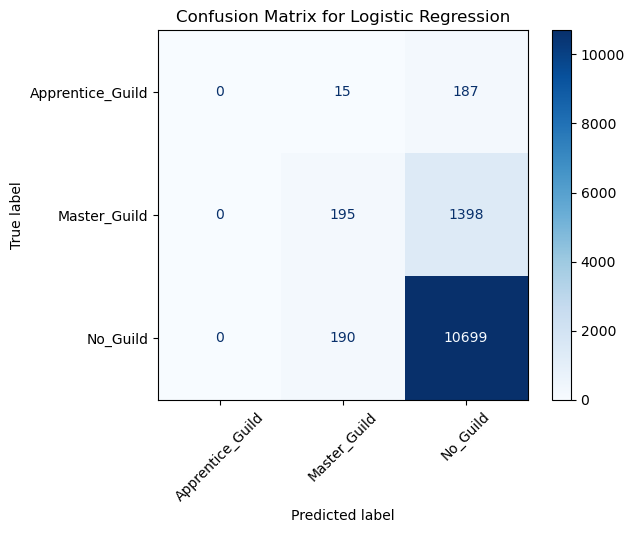

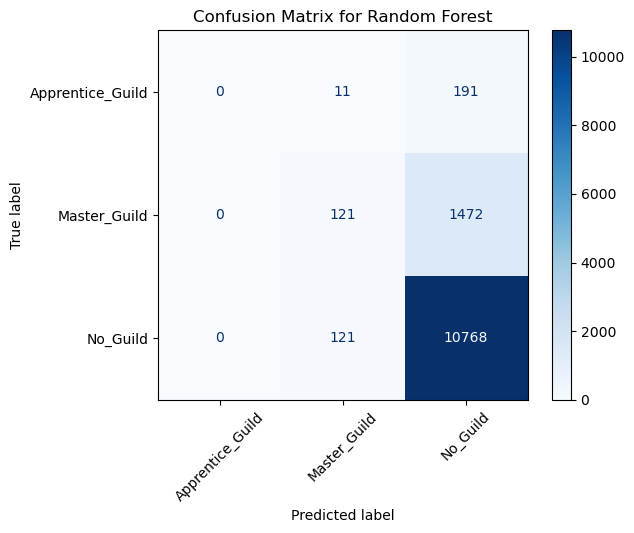

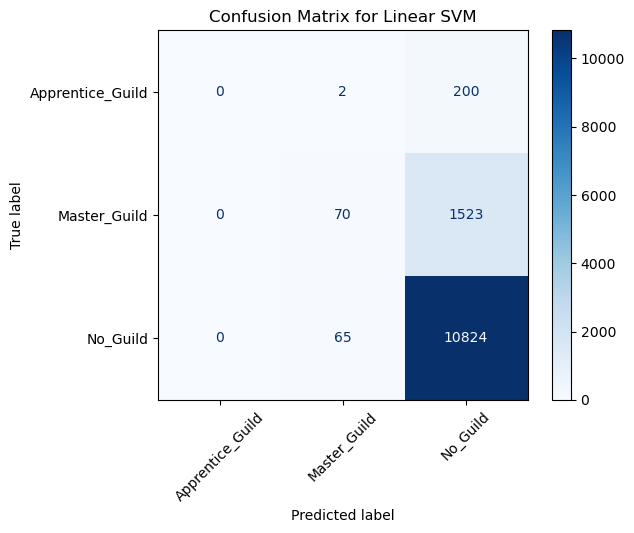

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for each model
for name, model in models.items():
    # Predict for confusion matrix
    if name in ["Logistic Regression", "Linear SVM"]:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()


### Classification Report Summaries
Each model's performance on precision, recall, and F1 score for all classes.


In [21]:
# Display classification report for each model
for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"\n===== {name} Classification Report =====")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



===== Logistic Regression Classification Report =====
                  precision    recall  f1-score   support

Apprentice_Guild       0.00      0.00      0.00       202
    Master_Guild       0.49      0.12      0.20      1593
        No_Guild       0.87      0.98      0.92     10889

        accuracy                           0.86     12684
       macro avg       0.45      0.37      0.37     12684
    weighted avg       0.81      0.86      0.82     12684


===== Random Forest Classification Report =====
                  precision    recall  f1-score   support

Apprentice_Guild       0.00      0.00      0.00       202
    Master_Guild       0.48      0.08      0.13      1593
        No_Guild       0.87      0.99      0.92     10889

        accuracy                           0.86     12684
       macro avg       0.45      0.35      0.35     12684
    weighted avg       0.80      0.86      0.81     12684


===== Linear SVM Classification Report =====
                  precision    r

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/l

### ROC Curve Analysis
ROC curves analyze the trade-off between true positive rate (TPR) and false positive rate (FPR) for different thresholds.


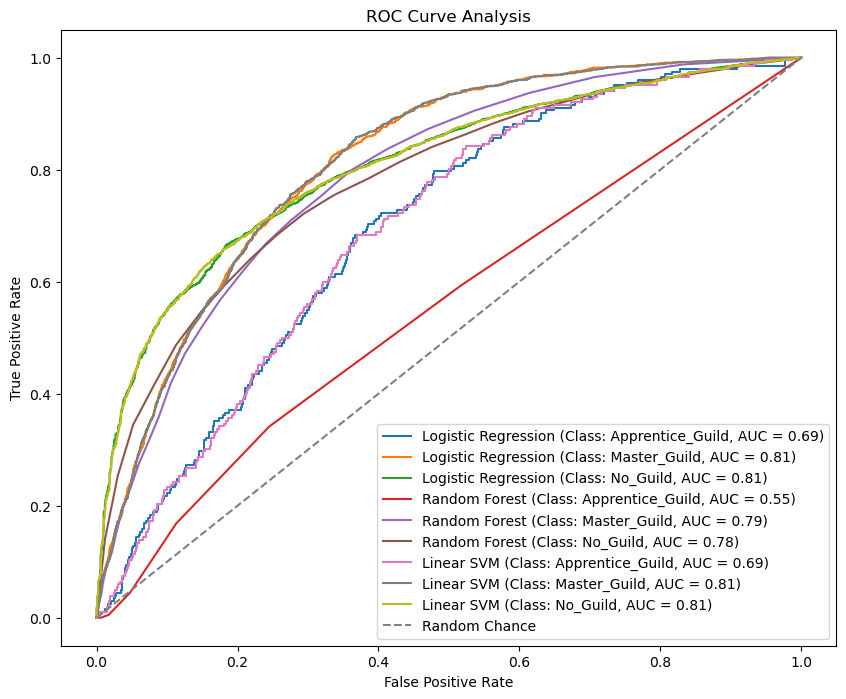

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize target for multi-class ROC curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Ensure model supports predict_proba
        y_proba = model.predict_proba(X_test)
        for i, class_label in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (Class: {class_label}, AUC = {roc_auc:.2f})")
    elif hasattr(model, "decision_function"):  # For Linear SVM
        y_score = model.decision_function(X_test)
        for i, class_label in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (Class: {class_label}, AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.title("ROC Curve Analysis")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
